1. \*Измените функцию `calc_logloss` так, чтобы нули по возможности не попадали в `np.log`.  
2. Подберите аргументы функции `eval_model` для логистической регрессии таким образом, чтобы ***log loss*** был минимальным.
3. Создайте функцию `calc_pred_proba`, возвращающую предсказанную вероятность класса 1 (на вход подаются `W`, который уже посчитан функцией `eval_model` и `X`, на выходе - массив `y_pred_proba`).
4. Создайте функцию `calc_pred`, возвращающую предсказанный класс (на вход подаются `W`, который уже посчитан функцией `eval_model` и `X`, на выходе - массив `y_pred`).
5. Посчитайте ***Accuracy***, матрицу ошибок, точность и полноту, а также ***F1 score***.
6. Могла ли модель переобучиться? Почему?
7. \* Создайте функции `eval_model_l1` и `eval_model_l2` с применением ***L1*** и ***L2*** регуляризаций соответственно.

--------


In [84]:
import numpy as np
import matplotlib.pyplot as plt

## Исходные функции и данные из урока:

In [85]:
def calc_logloss(y, y_pred):
    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    return err

def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

def eval_model(X, y, iterations, alpha=1e-4, metric: callable = None):
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T))
    if i % (iterations / 10) == 0:
        print(i, W, err)
    return W

In [86]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450,
               800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype = np.float64)

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

### 1.
***Измените функцию `calc_logloss` так, чтобы нули по возможности не попадали в `np.log`.**

Для удолбства сделаем свою реализацию `log`:

In [87]:
def log_custom(arr: np.array):
    '''
    Считается как количество успешно угаданных исходов к общему числу наблюдений
    
    Parameters
    ----------
    y1, y2: array
        Сравниваемые векторы
    
    Returns
    -------
    out : float
        Значение метрики
    '''
    arr = np.where(arr == 0, -np.inf, arr)
    arr[arr != -np.inf] = np.log(arr[arr != - np.inf])
    return arr


Таким образом перепишем изначальную функцию:

In [88]:
def calc_logloss_custom(y, y_pred):
    '''
    Считается как количество успешно угаданных исходов к общему числу наблюдений
    
    Parameters
    ----------
    y1, y2: array
        Сравниваемые векторы
    
    Returns
    -------
    out : float
        Значение метрики
    '''
    err = - np.mean(y * log_custom(y_pred) + (1.0 - y) * log_custom(1.0 - y_pred))
    return err

-----


### 2. 
**Подберите аргументы функции `eval_model` для логистической регрессии таким образом, чтобы *log loss* был минимальным**

Несколько поменяем функцию `eval_model` для наглядной визуализации

In [89]:
def eval_model(X: np.array, y: np.array, iterations: int, alpha: float=1e-4, metric: callable = None) -> tuple:
    '''
    Обучает модуель на основе логистической регрессии
    
    Parameters
    ----------
    X, y: array
        Исходная матрица признаков и вектор целевой переменной
    iterations: int
        Количество циклов обучений модели
    alpha: int
        Шаг обучения
    
    Returns
    -------
    out: tuple
        W: np.array
            Вектор весов
        res_err: list
            Список значений logloss через каждые 10 итераций
        res_W:list
            Список промежуточных весов через каждые 10 итераций
    '''
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    res_err, res_W = [], []
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss_custom(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T))
        if not i % 10:
            res_err.append(err)
            res_W.append(W)
    return W, res_err, res_W


In [90]:
W_pred, res_err, res_W = eval_model(X, y, 2000)

<ipython-input-88-24066150e876>:15: RuntimeWarning: invalid value encountered in multiply
  err = - np.mean(y * log_custom(y_pred) + (1.0 - y) * log_custom(1.0 - y_pred))


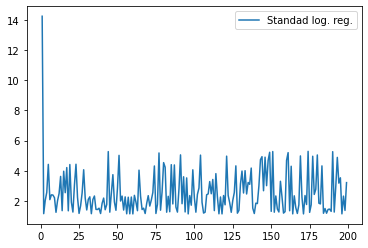

In [91]:
plt.plot(res_err, label='Standad log. reg.')
plt.legend()
plt.show()


Со стандартными атрибутами обучения мегко говоря не очень. Поэтому необходимо пересмотреть набор используемых гиперпараметров. Количество итераций не будет сильно влиять на итоговое качество модели при выходе на "плато", поэтому возьмем в качестве него какое-либо большое значение (а лучше использовать реализации с динамическим правилом останова). Остается только менять показатель шага обучения - `alpha`:

In [92]:
alpha_changes = dict()

for i in range(4, 11):
    W_pred, res_err, res_W = eval_model(X, y, 20000, alpha=10**(-i))
    alpha_changes[i] = res_err.copy()


<ipython-input-88-24066150e876>:15: RuntimeWarning: invalid value encountered in multiply
  err = - np.mean(y * log_custom(y_pred) + (1.0 - y) * log_custom(1.0 - y_pred))


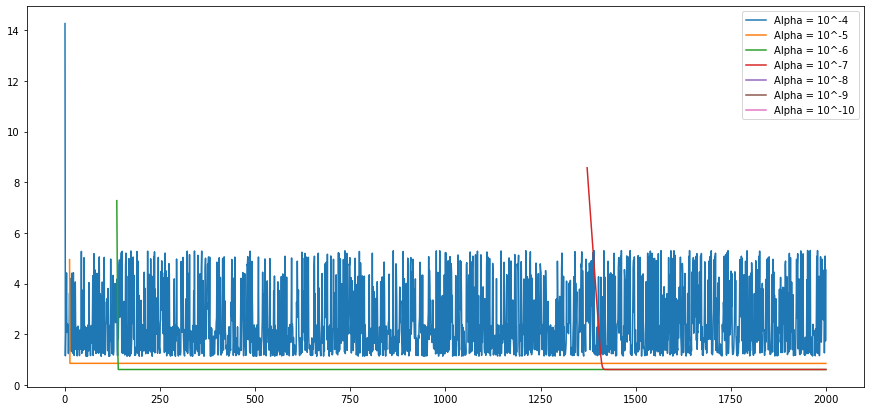

In [93]:
fig = plt.figure(figsize=(15, 7))
for step, res_err in alpha_changes.items():
    plt.plot(res_err, label=f'Alpha = 10^-{step}')
plt.legend()
plt.show()

Как видно, ниже чем при $\alpha = 10^{-6}$ значения `logloss` или не опускаются, или не существуют на данном отрезке (на графике не понятно, но отсекать такой вариант нельзя до проверки). Дополнительно проверим указанную степень:

In [94]:
alpha_changes = dict()

for i in range(9, 0, -1):
    W_pred, res_err, res_W = eval_model(X, y, 10000, alpha=i * 10**(-6))
    alpha_changes[i] = res_err.copy()

<ipython-input-88-24066150e876>:15: RuntimeWarning: invalid value encountered in multiply
  err = - np.mean(y * log_custom(y_pred) + (1.0 - y) * log_custom(1.0 - y_pred))


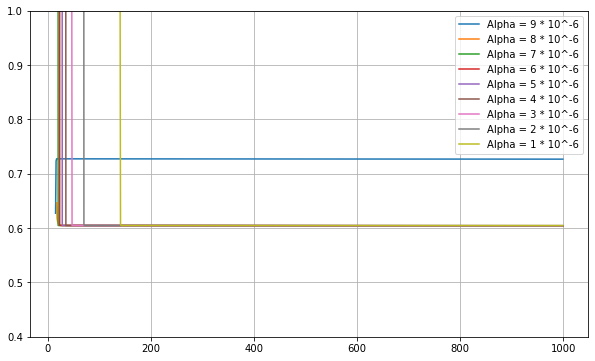

In [95]:
fig = plt.figure(figsize=(10, 6))
for step, res_err in alpha_changes.items():
    plt.plot(res_err, label=f'Alpha = {step} * 10^-6')
plt.ylim(0.4, 1)
plt.grid()
plt.legend()
plt.show()

Таким образом можно сделать вывод о том, что наименьшее значение `logloss` достигается при $\alpha \leq 8\cdot10^{-6}$, стабилизация метрики происходит приблизительно на 400-500 шаге. Для верности лучше взять ~1000.

Более высокие значения `alpha` брать нет смысла, так как алгоритм или не сойдется, или будет выше найденного. Более низкие также мало смысла - значение в итоге будет крайне близким к тому, что получилось в данном случае, однако количество итераций будет в разы больше.

----


### 3.
**Создайте функцию `calc_pred_proba`, возвращающую предсказанную вероятность класса 1 (на вход подаются `W`, который уже посчитан функцией `eval_model` и `X`, на выходе - массив `y_pred_proba`).**

In [96]:
def calc_pred_proba(X: np.array, W: np.array) -> np.array:
    '''
    Считает вероятность принадлежности элементов к классу 1
    , где sigmoid(x) = 1 / (1 + np.exp(-x))
    
    Parameters
    ----------
    X: array
        Значения признаков
    W: array
        Предсказанные веса
    
    Returns
    -------
    out : array
        Значения вероятнстей принадлежности к классу 1    
    '''
    return sigmoid(np.dot(W, X))

In [97]:
W_pred, res_err, res_W = eval_model(X, y, 1000, alpha=8e-6)
calc_pred_proba(X, W_pred)


<ipython-input-88-24066150e876>:15: RuntimeWarning: invalid value encountered in multiply
  err = - np.mean(y * log_custom(y_pred) + (1.0 - y) * log_custom(1.0 - y_pred))


array([0.65978007, 0.54388457, 0.80799964, 0.60328048, 0.40016864,
       0.51812339, 0.67186118, 0.23188964, 0.68651899, 0.69617738])

-----


### 4.
**Создайте функцию `calc_pred`, возвращающую предсказанный класс (на вход подаются `W`, который уже посчитан функцией `eval_model` и `X`, на выходе - массив `y_pred`).**

In [98]:
def calc_pred(X: np.array, W: np.array, threshold: float=0.5) -> np.array:
    '''
    Считает принадлежность элементов к классу 0 или 1
    , где sigmoid(x) = 1 / (1 + np.exp(-x))
    
    Parameters
    ----------
    X: array
        Значения признаков
    W: array
        Предсказанные веса
    threshold: float
        Порог вероятности, при котором класс считается равным 1
    
    Returns
    -------
    out : array
        Значения принадлежности к классу 0 или 1
    '''
    pred = calc_pred_proba(X, W)
    pred = np.where(pred >= threshold, 1, pred)
    pred = np.where(pred < threshold, 0, pred)
    
    return pred
    

In [99]:
calc_pred(X, W_pred)

array([1., 1., 1., 1., 0., 1., 1., 0., 1., 1.])

----


### 5.
**Посчитайте *Accuracy*, матрицу ошибок, точность и полноту, а также *F1 score***

In [100]:
def accuracy(y1: np.array, y2: np.array) -> np.array:
    '''
    Считается как количество успешно угаданных исходов к общему числу наблюдений
    
    Parameters
    ----------
    y1, y2: array
        Сравниваемые векторы
    
    Returns
    -------
    out : float
        Значение метрики
    '''
    acc = (y1 == y2).sum() / y1.shape[0]
    
    return acc

def metric_components(y_pred: np.array, y: np.array) -> np.array:
    '''
    Считает количество TP, TN, FP, FN вариантов угадываний
    
    Parameters
    ----------
    y_pred, y: array
        Предсказанная и целевая переменные
    
    Returns
    -------
    TP: int
    TN: int
    FP: int
    FN: int
        Значения метрик
    '''
    TP = (y_pred[y_pred == 1] == y[y_pred == 1]).sum()
    TN = (y_pred[y_pred == 0] == y[y_pred == 0]).sum()
    FP = (y_pred[y_pred == 1] != y[y_pred == 1]).sum()
    FN = (y_pred[y_pred == 0] != y[y_pred == 0]).sum()
    
    return TP, TN, FP, FN


In [101]:
y_pred = calc_pred(X, W_pred)
accuracy(y_pred, y)


0.5

In [102]:
TP, TN, FP, FN = metric_components(y_pred, y)
print(f'TP = {TP}, TN = {TN}, FP = {FP}, FN = {FN}')
print('----------')
print(f'y_pred', y_pred)
print(f'y     ', y)


TP = 4, TN = 1, FP = 4, FN = 1
----------
y_pred [1. 1. 1. 1. 0. 1. 1. 0. 1. 1.]
y      [0. 0. 1. 0. 1. 0. 1. 0. 1. 1.]


Т.е. матрица ошибок выглядит следуюим образом:


|  <empty>   | $$y = +1$$ | $$y = -1$$ |
--- | --- | ---
| __$$a_{1}(x) = +1$$__  |   4    |   4   |
| __$$a_{1}(x) = -1$$__ |   1    |   1   |

Расчет точности и полноты и F1 score:

In [103]:
def precision(y_pred: np.array, y: np.array) -> np.array:
    '''
    Считается как TP / (TP + FP)
    
    Parameters
    ----------
    y_pred, y: array
        Предсказанная и целевая переменные
    
    Returns
    -------
    out: float
        Значение метрики
    '''
    TP, TN, FP, FN = metric_components(y_pred, y)
    return TP / (TP + FN)

def recall(y_pred: np.array, y: np.array) -> np.array:
    '''
    Считается как TP / (TP + FN)
    
    Parameters
    ----------
    y_pred, y: array
        Предсказанная и целевая переменные
    
    Returns
    -------
    out: float
        Значение метрики
    '''
    TP, TN, FP, FN = metric_components(y_pred, y)
    return TP / (TP + FN)

def F1(y_pred: np.array, y: np.array) -> np.array:
    '''
    Считается как precision * recall / (precision + recall)
    
    Parameters
    ----------
    y_pred, y: array
        Предсказанная и целевая переменные
    
    Returns
    -------
    out: float
        Значение метрики
    '''
    prec = precision(y_pred, y)
    rec = recall(y_pred, y)
    
    return prec* rec / (prec + rec)


In [104]:
print(f'precision = {round(precision(y_pred, y), 5)}\nrecall = {round(recall(y_pred, y), 5)}\nF1 = {round(F1(y_pred, y), 5)}\n')

precision = 0.8
recall = 0.8
F1 = 0.4



-----


### 6.
**Могла ли модель переобучиться? Почему?**

В линейных моделях о возможности переобучения можно говорить с двух сторон: когда идет увеличение нелинейно зависимых столбцов или когда количество данных становится меньше. На самом деле в обоих случаях речь идет о сокращении разницы между количеством строк и столбцов. Ведь когда в НЛЗ системе количество столбцов (независимых переменных) будет равно количеству строк (количеству уравнений), то такая система будет иметь только 1 решение, что в рамках обучения модели будет иметь максимально деструктивный для нее эффект. Реагируя на любое значение функции, веса будут приниматься слишком большие по модулю значения.

Т.к. здесь присутствует 4 признака и 10 наблюдений, разница между этими величинами достаточно не выраженная, а также само количество наблдений крайне мало. С большой вероятностью модель могла переобучиться. Однако величины каких-либо весов не имеют слишком весомых перекосов (в десятки и сотни раз больше) по сравнению с другими (ниже также будет видно, что при применении ***Lasso*** и ***Ridge*** особых изменений в весах нет):


In [105]:
W_pred

array([ 0.49546817, -0.13969578, -0.00243162,  1.52234981])

### 7.
*** Создайте функции `eval_model_l1` и `eval_model_l2` с применением *L1* и *L2* регуляризаций соответственно.**

Возьмем за основу уже имеющуюся `eval_model` и подготовим комбинированную функцию для расчета ***L1*** или ***L2*** регуляризации:

In [106]:
def eval_model_l1_2(X, y, iterations=1000, alpha=8e-6, regularization='None', lambda_=1) -> tuple:
    '''
    Обучает модуель на основе логистической регрессии
    
    Parameters
    ----------
    X, y: array
        Исходная матрица признаков и вектор целевой переменной
    iterations: int
        Количество циклов обучений модели
    alpha: int
        Шаг обучения
    regularization: str
        Способ регуляризации модели. Доступные значения: 'L1', 'Lasso', 'L2', 'Ridge', 'None'.
    lambda_: float
        Коэффициент регуляризации со значениями >=0. Проявляет эффект только с корректно выбранным методом регуляризации.
    
    Returns
    -------
    out: tuple
        W: np.array
            Вектор весов
        res_err: list
            Список значений logloss через каждые 10 итераций
        res_W:list
            Список промежуточных весов через каждые 10 итераций
    '''
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    res_err, res_W = [], []
    L = 0
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss_custom(y, y_pred)
        if regularization in ['L1', 'Lasso']:
            L = np.sign(W)
        elif regularization in ['L2', 'Ridge']:
            L = 2 * W
        W -= alpha * (1/n * np.dot((y_pred - y), X.T) + L * lambda_)
        if not i % 10:
            res_err.append(err)
            res_W.append(W.copy())
    print(err)
    return W, res_err, res_W

<ipython-input-88-24066150e876>:15: RuntimeWarning: invalid value encountered in multiply
  err = - np.mean(y * log_custom(y_pred) + (1.0 - y) * log_custom(1.0 - y_pred))


0.6046626843597026


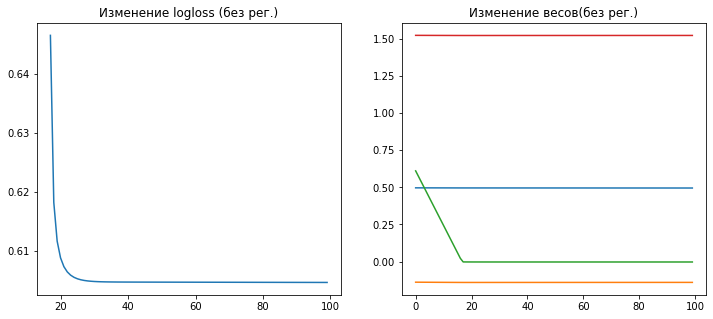

In [107]:
W_pred, res_err, res_W = eval_model_l1_2(X, y, regularization='None')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(res_err)
ax[0].set_title('Изменение logloss (без рег.)')
ax[1].plot(res_W)
ax[1].set_title('Изменение весов(без рег.)')
None


<ipython-input-88-24066150e876>:15: RuntimeWarning: invalid value encountered in multiply
  err = - np.mean(y * log_custom(y_pred) + (1.0 - y) * log_custom(1.0 - y_pred))


0.6039176707409074


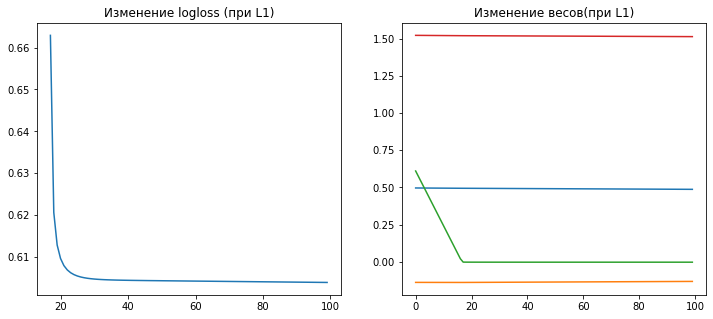

In [108]:
W_pred, res_err, res_W = eval_model_l1_2(X, y, regularization='L1')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(res_err)
ax[0].set_title('Изменение logloss (при L1)')
ax[1].plot(res_W)
ax[1].set_title('Изменение весов(при L1)')
None


<ipython-input-88-24066150e876>:15: RuntimeWarning: invalid value encountered in multiply
  err = - np.mean(y * log_custom(y_pred) + (1.0 - y) * log_custom(1.0 - y_pred))


0.6050263812788305


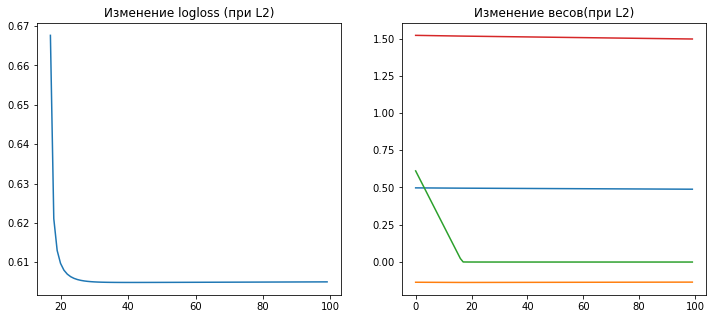

In [109]:
W_pred, res_err, res_W = eval_model_l1_2(X, y, regularization='L2')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(res_err)
ax[0].set_title('Изменение logloss (при L2)')
ax[1].plot(res_W)
ax[1].set_title('Изменение весов(при L2)')
None
